# Gaussian Processes
A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution.


$$
	\left[ \begin{array}{c} \mathbf{y} \\ {y}_* \end{array} \right]  \sim \mathcal{N}\left(\left[ \begin{array}{c} m(\mathbf{X}) \\ m(x_*) \end{array} \right] ,
	\begin{bmatrix} K(\mathbf{X}, \mathbf{X}) & K(\mathbf{X}, {x}_*) \\ K({x}_*, \mathbf{X}) & K({x}_*, {x}_*) \end{bmatrix} \right)
$$

$m(x)$ and $K(x,x)$ are the mean and the the coveriance (kernel) functions; respectively. 

Typically, zero mean fucntion:
\begin{eqnarray}
m(x)    = 0 
\end{eqnarray}

and squared-exponential kernel:
$$
K(x,x') = \sigma^2  exp\left( -\frac{1}{2l^2} (x-x')^2\right)
$$

### Model Hyperparameters
$$
\Theta = [\sigma, l]
$$

where $\sigma$ is the output variance and $l$ is the lengthscale

In [5]:
# define the squared exponential kernel and the mean function

def kernel(x1, x2, theta = [1,1]): 
    """   
                    GP squared exponential kernel
    x1 , x2: are x and x' data vectors in shape (n,1)  and (m,1)              
    theta: model hyperparameters [output variance, Lengthscale ]
    return the kernel matrix (n,m) of x1 and x2
    """
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    sqdist = np.power(dist.cdist(x1,x2,"euclidean"),2)
    #print(np.mean(np.abs(np.subtract(sqdist1,sqdist))))
    return (theta[0]**2)*np.exp(-.5 * (1/theta[1]**2) * sqdist)

def zero_mean(x):
    
    return np.zeros(len(x))

# Example (1)
Let's model a nonlinear system represented by sinc() function:

$$
f(x) = \frac{3\sin(\pi x)}{\pi x} 
$$

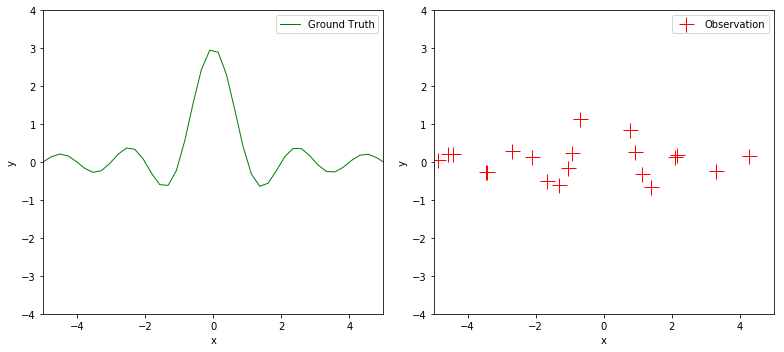

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
# This is the true unknown function we are trying to approximate
f = lambda x: (3/(np.pi*x) * np.sin(np.pi* x)).flatten()
# Sample some input points and noisy versions of the function evaluated at
# these points. 

N = 20         # number of training points.
n = 50         # number of test points.
s_d = 0.001    # noise variance.
ub = 7         # Upper bound of x values
lb = -5        # Lower bound of x values 
#X = np.random.uniform(-5, 5, size=(N,1))
X = np.array([[-4.42693341], [-0.68975284], [ 0.92068753], [-0.92635244], [-4.88387597], [-2.10250917], [ 1.11419467], \
           [-1.05398127], [ 2.0961461 ], [ 1.39070398], [ 3.30300148], [-4.57614395], [-3.41683113], [ 4.24835207], \
           [-2.70142658], [ 2.13917581], [-1.32635833], [ 0.76655255], [-3.47152763], [-1.67327578]]);
y = f(X)  + s_d*np.random.randn(N)


#plot prior model
plt.figure(1,figsize=(11,5))
plt.clf()
plt.subplot(121)
x= np.linspace(lb, ub, n).reshape(-1,1)
plt.plot(x, f(x), 'g-',lw=1,label=u'Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.axis([lb,-1*lb, -4, 4])
plt.legend()
plt.subplot(122)
x= np.linspace(lb, ub, n).reshape(-1,1)
plt.plot(X, y, 'r+', ms=15,label=u'Observation')
plt.xlabel('x')
plt.ylabel('y')
plt.axis([lb,-1*lb, -4, 4])
plt.tight_layout()
plt.legend()
plt.show()

## Prior Model  (No observation)



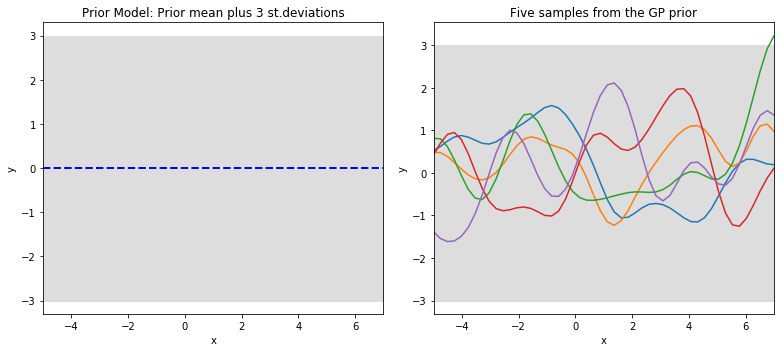

In [7]:
#Prior Model
# points we're going to make predictions at.
theta = [1,1]
Xtest = np.linspace(lb, ub, n).reshape(-1,1)

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest,theta)  
S2Ones = np.diag(K_)
# meam functin
muZero = zero_mean(Xtest)

# draw 10 samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = muZero.reshape(-1,1)+ np.dot(L, np.random.normal(size=(n,5)))

#plot prior model
plt.figure(2,figsize=(11,5))
plt.clf()
plt.subplot(121)

plt.gca().fill_between(Xtest.flat, muZero-3*S2Ones, muZero+3*S2Ones, color="#dddddd")
plt.plot(Xtest, muZero, 'b--', lw=2)
plt.title('Prior Model: Prior mean plus 3 st.deviations')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([lb,ub])


plt.subplot(122)
plt.plot(Xtest, f_prior)
plt.gca().fill_between(Xtest.flat, muZero-3*S2Ones, muZero+3*S2Ones, color="#dddddd")
plt.title('Five samples from the GP prior')
plt.xlim([lb,ub])
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()



# Posterior Model 


Given the data points $(\mathbf{X},\mathbf{Y})$
$$
f(y_*) \sim \mathcal{N}(y_* | \mathbf{X},\mathbf{Y},x_*)
$$

Thus, 
\begin{equation}
\begin{aligned}
 \mu_* &=  \mathbb{E}[y_* | \mathbf{y}, \mathbf{X},x_*] = m(x_*) + \mathbf{K}_*^T \boldsymbol{\beta} \\
 \sigma_* &= Var[y_* | \mathbf{y}, \mathbf{X}, x_*] = k_{**}-\mathbf{K}_{*}^T\mathbf{K}^{-1}\mathbf{K}_*\\
\end{aligned}
\end{equation}	
    


where $\mathbf{K}_* := k(\mathbf{X}, \mathbf{X}_*)$, $k_{**} := k(x_*, x_*)$, $\mathbf{K} := k(\mathbf{X}, \mathbf{X})$ and $\boldsymbol\beta := \mathbf{K}^{-1}(\mathbf{y} - m(\mathbf(X))$.

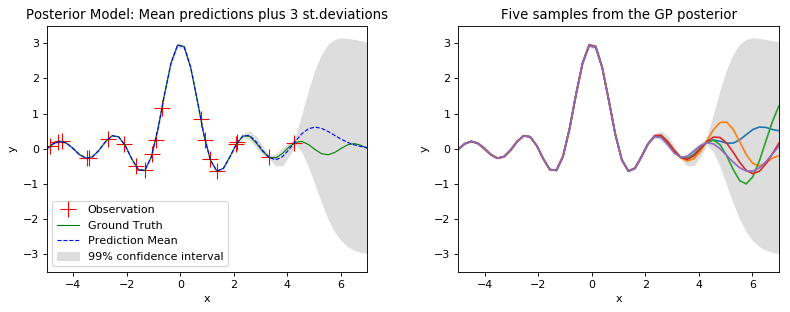

In [8]:
# Posterior Model

# Compute GP model
theta = [1,1]
K = kernel(X, X,theta)  #+ 1e-1*np.eye(len(X))  #noise kernel
L = np.linalg.cholesky(K + 1e-5*np.eye(N)) 
# points we're going to make predictions at.
Xtest = np.linspace(lb, ub, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest,theta))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest,theta)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)



L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,5)))



#plot Posterior model
plt.figure(3 ,figsize=(10,4), dpi=80, facecolor='w', edgecolor='k')
plt.clf()
plt.subplot(121)
plt.plot(X, y, 'r+', ms=15,label=u'Observation')
plt.plot(Xtest, f(Xtest), 'g-',lw=1,label=u'Ground Truth')
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd",label='99% confidence interval')
plt.plot(Xtest, mu, 'b--', lw=1,label=u'Prediction Mean')
plt.title('Posterior Model: Mean predictions plus 3 st.deviations')
plt.xlabel('x')
plt.ylabel('y')
plt.axis([lb, ub, -3.5, 3.5])
plt.legend()

plt.subplot(122)
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
plt.plot(Xtest, f_post)
plt.title('Five samples from the GP posterior')
plt.axis([lb, ub, -3.5, 3.5])
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## Model Learning

We aim to minimize the following likelihood function:

\begin{equation}
\begin{aligned}
	\hat{\Theta} =& \underset{\Theta}{\operatorname{argmax}}  \log p(\mathbf{y}|\Theta,\mathcal{D})\\
	 \log p(\mathbf{y}|\Theta,\mathcal{D}) =& -\frac{1}{2} \mathbf{y}^T\mathbf{K}^{-1}\mathbf{y}-\frac{1}{2}log(|\mathbf{K}|)-\frac{n}{2}log(2\pi).
	 \end{aligned}
\end{equation}

where $\mathcal{D} = \{ (x_i, y_i) | i = 1, ... , n \}$ is the training data

# Example (2)
Suppose we have systems with known linear dynamics $f_l$ and unknown nonlinear dynamics $f_n$. 

\begin{equation}
\begin{aligned}
y &= f_l(x) + f_n(x) \\
  &= (3x + 2) + 5\cos(3x)
	 \end{aligned}
\end{equation}


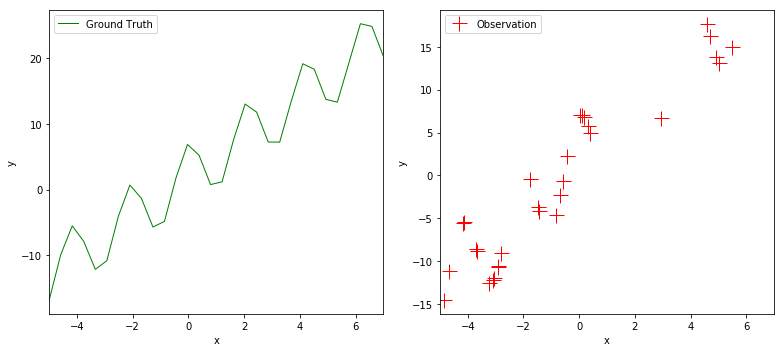

In [9]:
# This is the ground true unknown function we are trying to mode
f2 = lambda x: ((3*x + 2) + 5*np.cos(3*x)).flatten()
# Sample some input points and noisy versions of the function evaluated at
# these points. 

N = 30         # number of training points.
n = 30         # number of test points.
s_d = 0.00     # noise variance.
ub = 7         # Upper bound of x values
lb = -5        # Lower bound of x values 

# training data
X = np.random.uniform(lb, ub, size=(N,1))
y = f2(X) + 1e-3*np.random.randn(N)

#plot prior model
plt.figure(4,figsize=(11,5))
plt.clf()
plt.subplot(121)
x= np.linspace(lb, ub, n).reshape(-1,1)
plt.plot(x, f2(x), 'g-',lw=1,label=u'Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([lb,ub])
plt.legend()
plt.subplot(122)
x= np.linspace(lb, ub, n).reshape(-1,1)
plt.plot(X, y, 'r+', ms=15,label=u'Observation')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([lb,ub])
plt.tight_layout()
plt.legend()
plt.show()

In [10]:
def linear_mean(x):
    
    return (3*x + 2).flatten()

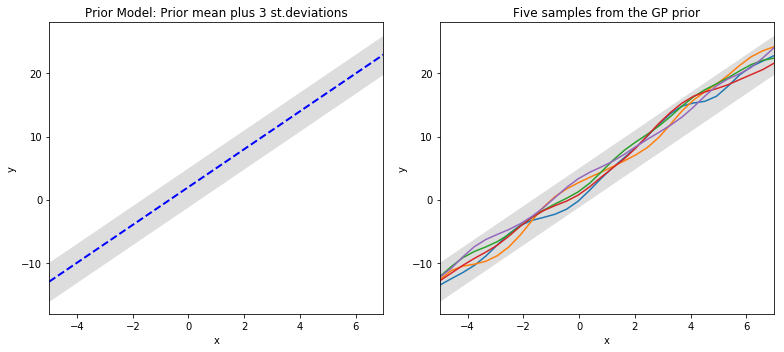

In [11]:
#Prior Model
# points we're going to make predictions at.
theta = [1,1]
Xtest = np.linspace(lb, ub, n).reshape(-1,1)

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest,theta)  
S2_prior = np.diag(K_)
# meam functin
mu_prior = linear_mean(Xtest)

# draw 10 samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-5*np.eye(n))
f_prior = mu_prior.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,5)))

#plot prior model
plt.figure(5,figsize=(11,5))
plt.clf()
plt.subplot(121)

plt.gca().fill_between(Xtest.flat, mu_prior-3*S2_prior, mu_prior+3*S2_prior, color="#dddddd")
plt.plot(Xtest, mu_prior, 'b--', lw=2)
plt.title('Prior Model: Prior mean plus 3 st.deviations')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([lb,ub])


plt.subplot(122)
plt.plot(Xtest, f_prior)
plt.gca().fill_between(Xtest.flat, mu_prior-3*S2_prior, mu_prior+3*S2_prior, color="#dddddd")
plt.title('Five samples from the GP prior')
plt.xlim([lb,ub])
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

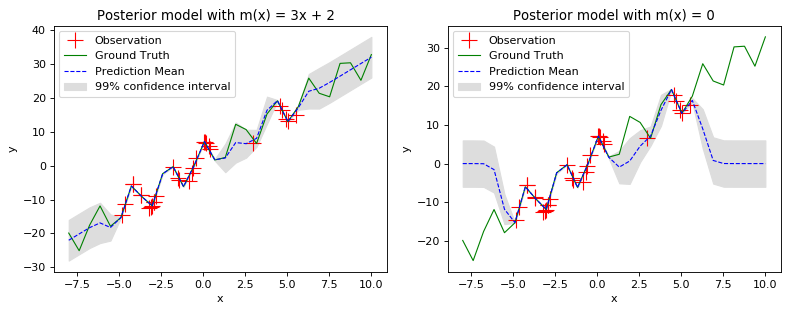

In [12]:
# Posterior Model


# Compute GP model
theta = [2,0.5]
K = kernel(X, X,theta)  #+ 1e-1*np.eye(len(X))  #noise kernel
L = np.linalg.cholesky(K + 1e-6*np.eye(N)) 
# points we're going to make predictions at.
Xtest = np.linspace(lb-3, ub + 3, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest,theta))
mu_x = linear_mean(X)
mu = linear_mean(Xtest) + np.dot(Lk.T, np.linalg.solve(L, (y - mu_x )))


mu0 = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest,theta)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)



#plot Posterior model
plt.figure(6 ,figsize=(10,4), dpi=80, facecolor='w', edgecolor='k')
plt.clf()
plt.subplot(121)
plt.plot(X, y, 'r+', ms=15,label=u'Observation')
plt.plot(Xtest, f2(Xtest), 'g-',lw=1,label=u'Ground Truth')
#plt.plot(Xtest, linear_mean(Xtest), 'y--',lw=1,label=u'Prior Model')
plt.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd",label='99% confidence interval')
plt.plot(Xtest, mu, 'b--', lw=1,label=u'Prediction Mean')
plt.title('Posterior model with m(x) = 3x + 2  ')
plt.xlabel('x')
plt.ylabel('y')
#plt.xlim([lb, ub])
plt.legend()

plt.subplot(122)
plt.plot(X, y, 'r+', ms=15,label=u'Observation')
plt.plot(Xtest, f2(Xtest), 'g-',lw=1,label=u'Ground Truth')
plt.gca().fill_between(Xtest.flat, mu0-3*s, mu0+3*s, color="#dddddd",label='99% confidence interval')
plt.plot(Xtest, mu0, 'b--', lw=1,label=u'Prediction Mean')
plt.title('Posterior model with m(x) = 0')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()